Medical data analysis for Belgium and Brussels

In [54]:
!pip install lime
!pip install shap
!pip install keplergl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 94.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922317 sha256=6cd0622b74ead5d7bf78c5e0ca36d68140099a9233458500a15370ecef4c2d2b
  Stored in directory: /root/.cache/pip/wheels/e5/e9/db/b8b8f2fcb5cb1cd7268d88959fce267bc00697cb8f50dcd0d9
Successfully built keplergl


In [2]:
from google.colab import drive
output_path = "/content/drive"
drive.mount(output_path)

Mounted at /content/drive


In [36]:
import sys
sys.path.append('Codes')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import lime
import lime.lime_tabular
import geopy.distance
from coordinates import Coordinate
from geopy.geocoders import Nominatim
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split


datasets = 'Datasets/'

aed = pd.read_parquet(datasets+'aed_locations.parquet.gzip')
ambulances =  pd.read_parquet(datasets+'ambulance_locations.parquet.gzip')
cad9 = pd.read_parquet(datasets+'cad9.parquet.gzip')
mugs = pd.read_parquet(datasets+'mug_locations.parquet.gzip')
pits = pd.read_parquet(datasets+'pit_locations.parquet.gzip')
interventions_bxl = pd.read_parquet(datasets+'interventions_bxl.parquet.gzip')
pd.set_option('display.max_columns', None)

In [37]:
def clean_interventions(interventions):
  interventions = interventions[interventions['Abandon reason'] == 'Verzorgd ter plaatse']
  interventions['T1'] = pd.to_datetime(interventions['T1'], format='%d%b%y:%H:%M:%S')
  interventions['T3'] = pd.to_datetime(interventions['T3'])
  interventions['Arrival time'] = (interventions['T3']-interventions['T1']).dt.total_seconds()
  event_types = ['P003 - Cardiac arrest','P019 - Unconscious - syncope', 'P028 - Drowning - diving accident', 'P030 - Hanging and strangulation', 'P033 - Trauma']
  interventions = interventions[interventions['EventType Firstcall'].isin(eventTypes)]
  interventions = interventions[['CityName intervention', 'Latitude permanence', 'Longitude permanence', 'Latitude intervention', 'Longitude intervention', 'Arrival time']]
  interventions = interventions.dropna(subset = ['Latitude permanence', 'Longitude permanence', 'Latitude intervention', 'Longitude intervention', 'Arrival time'])
  return interventions

def fix_coordinates_lat(x):
  while x > 10:
    x = x/10.
  x = x * 10
  return x

def fix_coordinates_long(x):
  while x > 1:
    x = x/10.
  x = x * 10
  return x


def clean_interventions_bxl(interventions):
  interventions = interventions[interventions['abandon_reason'] == 'Verzorgd ter plaatse']
  interventions['t1'] = pd.to_datetime(interventions['t1'])
  interventions['t3'] = pd.to_datetime(interventions['t3'])
  interventions = interventions[['t1', 't3', 'eventtype_trip', 'latitude_permanence', 'longitude_permanence', 'latitude_intervention', 'longitude_intervention']]
  interventions = interventions.dropna()
  interventions['Arrival time'] = (interventions['t3']-interventions['t1']).dt.total_seconds()
  interventions = interventions[interventions['eventtype_trip'].str.contains("P019|P029|P003|P033|P007|P028|P030|P001|P005")]
  intervention = pd.DataFrame()
  intervention[['Latitude permanence', 'Longitude permanence', 'Latitude intervention', 'Longitude intervention', 'Arrival time']] = interventions[[ 'latitude_permanence', 'longitude_permanence', 'latitude_intervention', 'longitude_intervention', 'Arrival time']]
  interventions = intervention
  interventions = interventions.dropna(subset = ['Latitude permanence', 'Longitude permanence', 'Latitude intervention', 'Longitude intervention', 'Arrival time'])
  interventions['Latitude permanence'] = interventions['Latitude permanence'].apply(Coordinate.fix_coordinates_lat)
  interventions['Longitude permanence'] = interventions['Longitude permanence'].apply(Coordinate.fix_coordinates_long)
  interventions['Latitude intervention'] = interventions['Latitude intervention'].apply(Coordinate.fix_coordinates_lat)
  interventions['Longitude intervention'] = interventions['Longitude intervention'].apply (Coordinate.fix_coordinates_long)
  return interventions

def get_coordinates(address):
    try:
        location = Nominatim(user_agent="EdwinTrident").geocode(address)
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except Exception as e:
        print(f"Error: {e}")
        return (0, 0)


Cleaning the data

In [38]:
                                          aed = aed.dropna()
aed.loc[:, ['id', 'number', 'postal_code']] = aed[['id','number','postal_code']].astype(int)

interventions_bxl = clean_interventions_bxl(interventions_bxl)
correlation_matrix = interventions_bxl.corr()
print(correlation_matrix)
isolation_forest = IsolationForest(contamination= 'auto')
interventions_bxl['anomaly'] = isolation_forest.fit_predict(interventions_bxl['Arrival time'].values.reshape(-1,1))
# Filter out the anomalies
interventions_bxl = interventions_bxl[interventions_bxl['anomaly'] == 1].drop(columns='anomaly')
interventions_bxl

cad9 = cad9.dropna()
#Possibly check if Name destination hospital,service name,unite_ID influences anything
columns_to_drop = ['Mission ID','Permanence short name', 'Permanence long name', 'Province invervention', 'EventSubType Trip', 'CityName intervention', 'CitysectionName intervention', 'Name destination hospital', 'MISSION_NR', 'AMBUCODE', 'UI', 'ID', 'T1confirmed', 'province', 'Service Name', 'UNIT_ID']
cad9 = cad9.drop(columns_to_drop, axis=1)
T = pd.DataFrame()
#maybe add a pie chart to see the proportions of time took of T#
cad9['T1'] = pd.to_datetime(cad9['T1'], format='%d%b%y:%H:%M:%S')
for i in range(8):
  if (i == 1):
    continue
  T['T'+str(i)] = pd.to_datetime(cad9['T'+str(i)])
  if i == 3:
    continue
  cad9 = cad9.drop(['T'+str(i)], axis=1)


<ipython-input-37-dfa8c887b767>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions['t1'] = pd.to_datetime(interventions['t1'])
<ipython-input-37-dfa8c887b767>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions['t3'] = pd.to_datetime(interventions['t3'])


                        Latitude permanence  Longitude permanence  \
Latitude permanence                1.000000             -0.140901   
Longitude permanence              -0.140901              1.000000   
Latitude intervention              0.909649             -0.143270   
Longitude intervention            -0.052102              0.870505   
Arrival time                      -0.057319             -0.007216   

                        Latitude intervention  Longitude intervention  \
Latitude permanence                  0.909649               -0.052102   
Longitude permanence                -0.143270                0.870505   
Latitude intervention                1.000000               -0.050185   
Longitude intervention              -0.050185                1.000000   
Arrival time                        -0.095706               -0.015157   

                        Arrival time  
Latitude permanence        -0.057319  
Longitude permanence       -0.007216  
Latitude intervention      -0

In [39]:
#creating a new column for tracking distance between intervention and vector
cad9['Distance'] = cad9.apply(
    lambda row: geopy.distance.geodesic(
        (row['Latitude permanence'], row['Longitude permanence']),
        (row['Latitude intervention'], row['Longitude intervention'])
    ).km,
    axis=1
)

interventions_bxl['Distance'] = interventions_bxl.apply(
    lambda row: geopy.distance.geodesic(
        (row['Latitude permanence'], row['Longitude permanence']),
        (row['Latitude intervention'], row['Longitude intervention'])
    ).km,
    axis=1
)

Calculating average time between call and arrival

In [40]:
cad9['T3'] = pd.to_datetime(cad9['T3'])
cad9['Arrival time'] = (cad9['T3']-cad9['T1'])

#dropping negative response times from table
cad9 = cad9[cad9['Arrival time'].apply(lambda x: x.days) >= 0]
average_response = cad9['Arrival time'].mean()
print("The average response time in Belgium is: "+str(average_response.seconds // 60)+" minutes "+str(average_response.seconds%60)+" seconds")
average_response = interventions_bxl['Arrival time'].mean()
print("While, the average response time in Brussels is: "+str(average_response // 60)+" minutes "+str(int(average_response%60))+" seconds")

The average response time in Belgium is: 12 minutes 47 seconds
While, the average response time in Brussels is: 7.0 minutes 35 seconds


In [41]:
cad9.groupby('Vector Type')['Arrival time'].mean()

,Arrival time
Vector Type,
Ambulance,0 days 00:12:28.992048767
MUG,0 days 00:14:09.497787610
PIT,0 days 00:12:16.130812151


EventLevel seems to influence Arrival time

In [42]:
cad9.groupby('EventLevel Trip')['Arrival time'].mean().sort_values()
#np.corrcoef(([cad9['Arrival time'].dt.total_seconds()/60, cad9['EventLevel Trip']]))

,Arrival time
EventLevel Trip,
N8,0 days 00:07:09
N7,0 days 00:09:29.666666666
L,0 days 00:10:37
N6,0 days 00:11:33.096000
N5,0 days 00:11:44.293393057
N4,0 days 00:11:51.431986340
N3,0 days 00:13:32.161191749
N1,0 days 00:14:24.454328832
N2,0 days 00:14:26.387458745


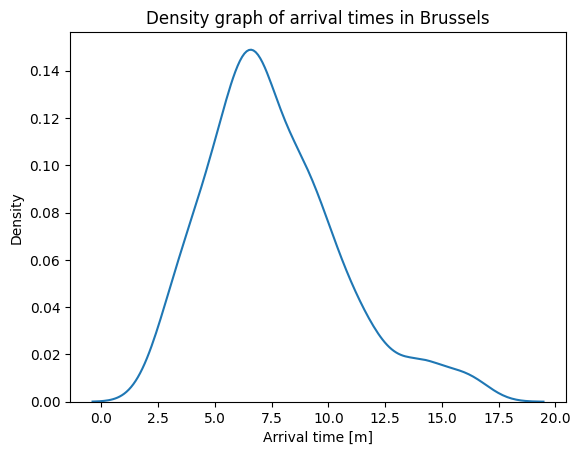

In [43]:
#plt.hist(interventions_bxl['Arrival time'] , bins = 200, density = True)
sns.kdeplot(interventions_bxl['Arrival time']/60)
plt.xlabel('Arrival time [m]')
plt.title('Density graph of arrival times in Brussels')
plt.show()

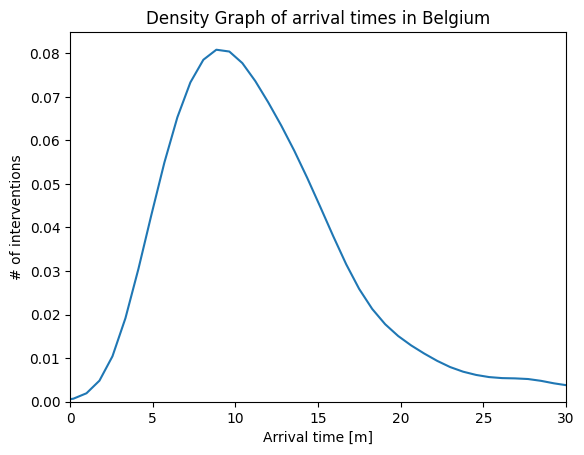

In [44]:
sns.kdeplot(cad9['Arrival time'].apply(lambda x: x.seconds / 60))
#plt.kdeplot(cad9['Arrival time'].apply(lambda x: x.seconds / 60), bins = 400)
plt.xlabel('Arrival time [m]')
plt.ylabel('# of interventions')
plt.title('Density Graph of arrival times in Belgium')
plt.xlim(0,30)
plt.show()


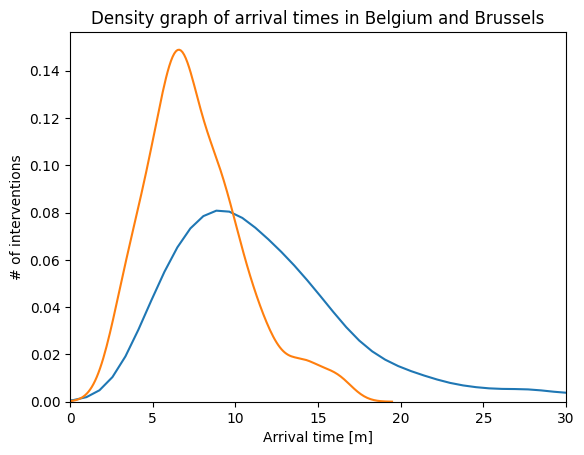

In [45]:
sns.kdeplot(cad9['Arrival time'].apply(lambda x: x.seconds / 60), legend = "Belgium")
sns.kdeplot(interventions_bxl['Arrival time']/60, legend = "Brussels")
plt.xlabel('Arrival time [m]')
plt.ylabel('# of interventions')
plt.title('Density graph of arrival times in Belgium and Brussels')
plt.xlim(0,30)
plt.show()

The results indicate a positive corelation between the arrival time and distance for Brussels:

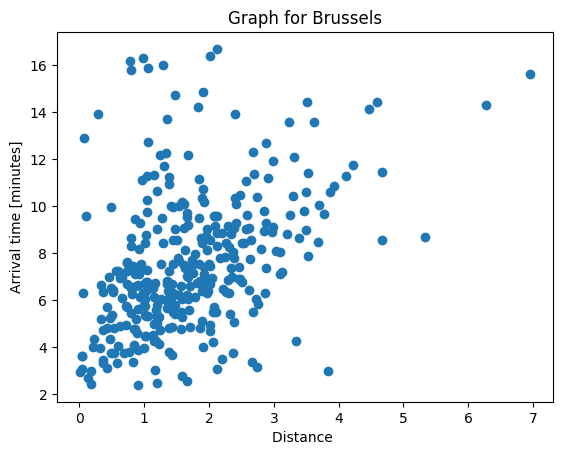

[[1.         0.41671557]
 [0.41671557 1.        ]]


In [46]:
plt.scatter(interventions_bxl['Distance'],interventions_bxl['Arrival time']/60, marker = 'o', )
plt.ylabel('Arrival time [minutes]')
plt.xlabel('Distance ')
plt.title('Graph for Brussels')
plt.show()
#pearson correlation coefficient matrix
print(np.corrcoef([interventions_bxl['Arrival time']/60, interventions_bxl['Distance']]))

The results below indecate that there is a weak positive corelation between the variables for Belgium, noticebly weaker than Brussels:

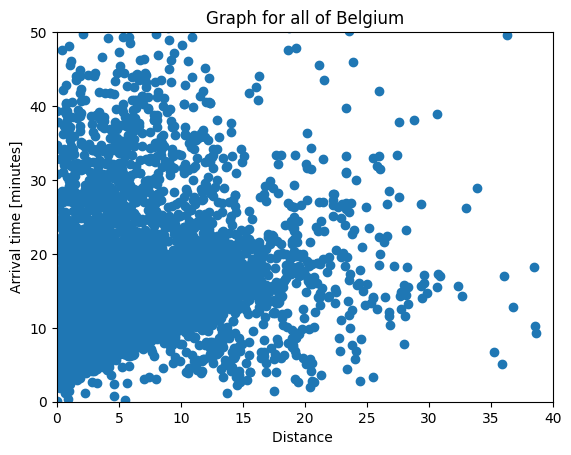

[[1.         0.33360513]
 [0.33360513 1.        ]]


In [47]:
plt.scatter(cad9['Distance'],cad9['Arrival time'].dt.total_seconds()/60, marker = 'o', )
plt.ylim(0,50)
plt.xlim(0,40)
plt.ylabel('Arrival time [minutes]')
plt.xlabel('Distance ')
plt.title('Graph for all of Belgium')
plt.show()
#pearson correlation coefficient matrix
print(np.corrcoef([cad9['Arrival time'].dt.total_seconds()/60, cad9['Distance']]))

Cleaning the interventions dataset

In [48]:
####Remember to redo isolation forest
aed_bxl = aed[aed['province'] == 'Bruxelles-Brussel']
aed_bxl['Full Address'] = aed_bxl['address'].astype(str)+' '+aed_bxl['number'].astype(int).astype(str)
aed_bxl['Coordinates'] = aed_bxl['Full Address'].apply(lambda x: (get_coordinates(x)))


<ipython-input-48-9c00b5ff6304>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_bxl['Full Address'] = aed_bxl['address'].astype(str)+' '+aed_bxl['number'].astype(int).astype(str)


Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Rue+Comte+de+Flandre+15&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=place+de+la+reine+Paola+11&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=rue+de+la+Station++17&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


<ipython-input-48-9c00b5ff6304>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_bxl['Coordinates'] = aed_bxl['Full Address'].apply(lambda x: (get_coordinates(x)))


In [49]:
aed_bxl2 = pd.DataFrame()
#They are rounded so that only the first 2 decimals are counted which is aproximatelly equal to
# ~700m rounded, so that coordinates that are walkable are counted the same when looking AED
(aed_bxl2['Latitude']) = aed_bxl['Coordinates'].apply(lambda x: (round(x[0]*100)/100)if x[0] is not None else None)
aed_bxl2['Longitude'] = aed_bxl['Coordinates'].apply(lambda x:  round(x[1]*100)/100 if x[1] is not None else None)
aed_bxl2 = aed_bxl2[aed_bxl2['Longitude'] > 0].dropna()
aed_bxl2 = aed_bxl2[aed_bxl2['Latitude'] > 0]
aed_bxl2.to_csv('DataFrame_with_Icon_Data.csv', index = False)
print(aed_bxl2.groupby(['Latitude', 'Longitude']).size().sort_values(ascending = False))

Latitude  Longitude
50.85     4.37         8
50.84     4.36         3
          4.43         3
50.83     4.39         3
50.85     4.36         3
50.84     4.45         2
50.85     4.34         2
          4.35         2
50.83     4.40         2
          4.37         2
50.85     4.45         2
50.82     4.37         2
          4.29         2
          4.27         2
50.86     4.37         2
50.87     4.40         2
50.84     4.39         2
50.86     4.34         1
          4.36         1
          4.33         1
          4.30         1
          4.41         1
          4.42         1
50.87     4.34         1
          4.35         1
          4.38         1
50.88     4.32         1
          4.36         1
          4.38         1
50.89     4.43         1
43.59     1.46         1
50.84     4.38         1
          4.37         1
48.80     2.41         1
49.08     6.19         1
50.22     5.34         1
50.30     4.33         1
50.40     4.48         1
50.80     4.30         1
     

,Latitude,Longitude
1138,50.85,4.37
10309,50.84,4.36
10310,50.84,4.36
10312,50.85,4.37
10338,50.83,4.34
...,...,...
15002,50.80,4.42
15003,50.83,4.39
15004,50.83,4.39
15092,50.85,4.36


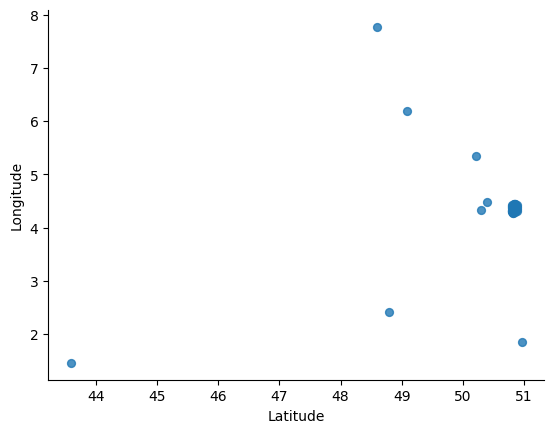

In [50]:
from matplotlib import pyplot as plt
aed_bxl2.plot(kind='scatter', x='Latitude', y='Longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [51]:
#breathing = ['P019 - BEWUSTELOOS - COMA - SYNCOPE', 'P033 - TRAUMA', 'P038 - PATIËNT BEANTWOORDT DE OPROEP NIET']
cad9_filtered = cad9[cad9['EventType Trip'].str.contains("P019|P029|P003|P033|P007|P028|P030|P001|P005")]


Using Random Forest

Mean Absolute Error: 254.15 seconds


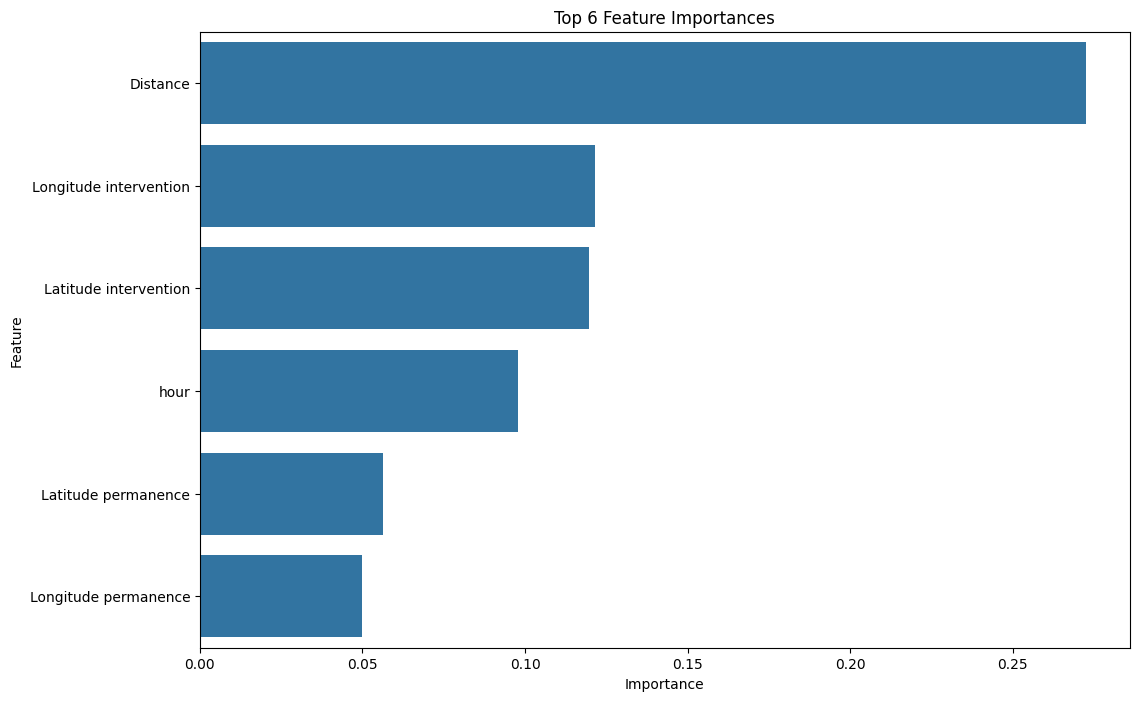

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import joblib

# Load the dataset
cad9_cleaned = cad9

# Drop unwanted columns
cad9_cleaned = cad9_cleaned.drop(columns=['T1' ,'T3', 'Intervention time (T1Reported)', 'Intervention time (T1Confirmed)', 'Departure time (T1Reported)', 'Departure time (T1Confirmed)'])
cad9_cleaned['hour'] = cad9['T1'].dt.second/3600


# Separate features and target variable
X = cad9_cleaned.drop(['Arrival time'], axis=1)
y = cad9_cleaned['Arrival time'].dt.seconds

# Handle categorical variables by creating dummy variables
X = pd.get_dummies(X)

# Save the column names before imputation
feature_names = X.columns.tolist()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

imputer = SimpleImputer(strategy='mean')
X_test = imputer.fit_transform(X_test)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(rf, 'random_forest_model.joblib')

# Make predictions and evaluate the model
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f} seconds')

# Get feature importances
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(6))
plt.title('Top 6 Feature Importances')
plt.show()


In [53]:

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['time'], mode='regression')

# Explain a single prediction (for example, the first test instance)
i = 0  # index of the test instance to explain
exp = explainer.explain_instance(X_test[i], rf.predict, num_features=6)

# Print the explanation
exp.show_in_notebook(show_table=True)

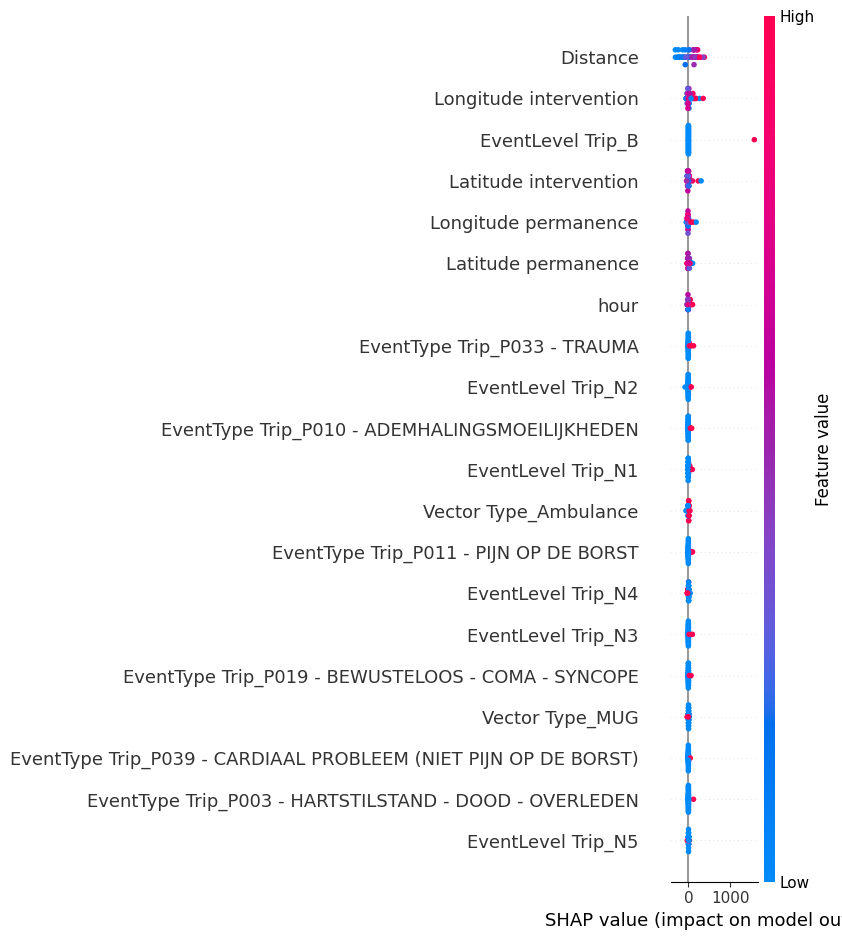

In [ ]:

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf)

X_test = X_test[:50]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the summary of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Plot the SHAP values for a single prediction (for example, the first test instance)
shap.force_plot(explainer.expected_value, shap_values[i], X_test[i], feature_names=feature_names)

In [89]:
from keplergl import KeplerGl
from google.colab import output
from ipywidgets import Button, Text, HBox, VBox
from IPython.display import display, clear_output

output.enable_custom_widget_manager()

# Initialize Kepler.gl map with initial data
aed_map = X
aed_map['Latitude'] = aed_map['Latitude permanence']
aed_map['Longitude'] = aed_map['Longitude permanence']
# Create input widgets for latitude and longitude
latitude_input = Text(description="Latitude:")
longitude_input = Text(description="Longitude:")

# Create a button widget
delete_button = Button(description="Delete Selected Point")

# Function to delete a point from the dataset based on input latitude and longitude
def delete_point_from_map(b):
    global aed_map, map_1

    # Get the input latitude and longitude values
    try:
        lat = float(latitude_input.value)
        lon = float(longitude_input.value)
    except ValueError:
        print("Please enter valid numeric values for latitude and longitude.")
        return

    # Check if there is any point with the specified latitude and longitude
    point_to_delete = aed_map[(aed_map['Latitude'] == lat) & (aed_map['Longitude'] == lon)]

    if not point_to_delete.empty:
        # Remove the point from the dataset
        aed_map = aed_map.drop(point_to_delete.index)

        # Update the map with the modified dataset
        map_1 = KeplerGl(height=600)
        map_1.add_data(data=aed_map, name='AED Locations')
        clear_output()  # Clear previous output
        display(delete_controls)  # Re-display the controls (inputs and button)
        display(map_1)
    else:
        print("No point found with the given latitude and longitude!")

# Attach the function to the button
delete_button.on_click(delete_point_from_map)

# Combine the inputs and button into a single layout
delete_controls = VBox([HBox([latitude_input, longitude_input]), delete_button])

# Display the input fields and button
display(delete_controls)

# Initialize and display the Kepler.gl map with initial data
map_1 = KeplerGl(height=600)
map_1.add_data(data=aed_map, name='AED Locations')
display(map_1)


NameError: name 'outut' is not defined